# Exploratory Analysis of Automatically Generated Text Corpus

In [1]:
# Imports
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.metrics.oov_words import OOVWords
from src.metrics.transrate import TransRate
from src.metrics.cosine_similarity import CosineSimilarity
from src.tools.text_processing import normalize_text, remove_punctuation
from src.tools.utils import z_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer

import pandas as pd

from tqdm.notebook import tqdm, trange
tqdm.pandas()

import string

import matplotlib.pyplot as plt
from src.visualization.visualize import plot_histogram
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from collections import Counter

import openai

from dotenv import load_dotenv, find_dotenv
import os

import tiktoken
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
%pwd

'/mnt/rufus_A/multimemo/notebooks'

In [3]:
# Set up openai embedding model
# Get environment variables

load_dotenv(find_dotenv())

openai.api_type = "azure"
openai.api_key = os.environ.get('OPENAI_API_KEY')
openai.api_base = os.environ.get('OPENAI_API_BASE')
openai.api_version = os.environ.get('OPENAI_API_VERSION')

In [2]:
load_dotenv(find_dotenv())

openai.api_key = os.environ.get('OPENAI_API_KEY')

In [2]:
# Load data
data = pd.read_json('../data/processed/memento_data_recaption.json')
data_exp = data.explode(['captions', 'recaptions'], ignore_index=True)
print(f"Loaded {len(data_exp)} captions.")

Loaded 42500 captions.


In [3]:
# Remove punctuation

data_exp['captions'] = data_exp['captions'].apply(lambda x: remove_punctuation(x))
data_exp['recaptions'] = data_exp['recaptions'].apply(lambda x: remove_punctuation(x))

## OOV words

In [4]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
tokenizer_openai = tiktoken.get_encoding("cl100k_base")
device = "cuda"
model.to(device)

oov_metric = OOVWords(model, tokenizer, device)
oov_metric_openai = OOVWords(model, tokenizer_openai, device)

In [17]:
data_exp['caption_oov_words'] = oov_metric.get_metric(data_exp['captions'].values, notebook=True)
print(f"Successfully computed OOV for {len(data_exp)} captions.")
print(f"Sample caption OOV: {data_exp['caption_oov_words'].values[:5]}")
data_exp['recaption_oov_words'] = oov_metric.get_metric(data_exp['recaptions'].values, notebook=True)
print(f"Successfully computed OOV for {len(data_exp)} recaptions.")
print(f"Sample recaption OOV: {data_exp['recaption_oov_words'].values[:5]}")

OOV words:   0%|          | 0/42500 [00:00<?, ?it/s]

OOV words: 100%|██████████| 42500/42500 [00:20<00:00, 2118.83it/s]


Successfully computed OOV for 42500 captions.
Sample caption OOV: [2 0 0 1 0]


OOV words: 100%|██████████| 42500/42500 [00:20<00:00, 2093.21it/s]

Successfully computed OOV for 42500 recaptions.
Sample recaption OOV: [0 1 1 1 1]


In [36]:
data_exp_openai = data_exp.copy()
data_exp_openai['caption_oov_words'] = oov_metric_openai.get_metric(data_exp['captions'].values, notebook=True)
print(f"Successfully computed OOV for {len(data_exp_openai)} captions.")
print(f"Sample caption OOV: {data_exp_openai['caption_oov_words'].values[:5]}")
data_exp_openai['recaption_oov_words'] = oov_metric_openai.get_metric(data_exp['recaptions'].values, notebook=True)
print(f"Successfully computed OOV for {len(data_exp_openai)} recaptions.")
print(f"Sample recaption OOV: {data_exp_openai['recaption_oov_words'].values[:5]}")

OOV words: 100%|██████████| 42500/42500 [03:51<00:00, 183.45it/s]  


Successfully computed OOV for 42500 captions.
Sample caption OOV: [2 1 1 4 2]


OOV words: 100%|██████████| 42500/42500 [00:02<00:00, 15804.95it/s]

Successfully computed OOV for 42500 recaptions.
Sample recaption OOV: [5 2 5 4 7]


In [21]:
high_oov_captions = data_exp[data_exp['caption_oov_words'] > 0]
high_oov_captions[['captions', 'caption_oov_words']].head(10)

,captions,caption_oov_words
0,A brown hair girl with lip piercings mumbles s...,2
3,A young woman wearing a striped shirt who has ...,1
10,A person wearing a white sleeveless shirt is c...,1
11,A fat woman claps and hits the table while spe...,1
12,A larger woman in a white tank top claps her h...,1
14,A brunette sings and claps before in front of ...,1
20,Two overweight women sway next to each other a...,1
22,Two morbidly obese women dance and sing in a r...,2
24,two fatties stand around and sing while swayin...,1
36,The lower part of a womans face neck and shoul...,1


In [30]:
no_oov = data_exp[data_exp['caption_oov_words'] == 0]
print(no_oov.shape)

(28780, 13)


In [29]:
no_oov = data_exp[data_exp_openai['caption_oov_words'] == 0]
print(no_oov.shape)

(2374, 13)


In [27]:
# Percentage of OOV words in the captions and recaptions corpus
total_words_in_captions_corpus = 0
total_oov_words_in_captions_corpus = 0
total_words_in_recaptions_corpus = 0
total_oov_words_in_recaptions_corpus = 0
for _, row in tqdm(data_exp.iterrows(), total=data_exp.shape[0], desc="OOV words"):
    total_words_in_captions_corpus += len(row['captions'].split())
    total_words_in_recaptions_corpus += len(row['recaptions'].split())
    total_oov_words_in_captions_corpus += row['caption_oov_words']
    total_oov_words_in_recaptions_corpus += row['recaption_oov_words']
print(f"Percentage of OOV words in the captions corpus: {total_oov_words_in_captions_corpus/total_words_in_captions_corpus*100:.2f}%")
print(f"Percentage of OOV words in the recaptions corpus: {total_oov_words_in_recaptions_corpus/total_words_in_recaptions_corpus*100:.2f}%")


OOV words:   0%|          | 0/42500 [00:00<?, ?it/s]

Percentage of OOV words in the captions corpus: 2.98%
Percentage of OOV words in the recaptions corpus: 9.89%


In [28]:
# Percentage of OOV words in the captions and recaptions corpus
total_words_in_captions_corpus = 0
total_oov_words_in_captions_corpus = 0
total_words_in_recaptions_corpus = 0
total_oov_words_in_recaptions_corpus = 0
for _, row in tqdm(data_exp_openai.iterrows(), total=data_exp_openai.shape[0], desc="OOV words"):
    total_words_in_captions_corpus += len(row['captions'].split())
    total_words_in_recaptions_corpus += len(row['recaptions'].split())
    total_oov_words_in_captions_corpus += row['caption_oov_words']
    total_oov_words_in_recaptions_corpus += row['recaption_oov_words']
print(f"Percentage of OOV words in the captions corpus: {total_oov_words_in_captions_corpus/total_words_in_captions_corpus*100:.2f}%")
print(f"Percentage of OOV words in the recaptions corpus: {total_oov_words_in_recaptions_corpus/total_words_in_recaptions_corpus*100:.2f}%")


OOV words:   0%|          | 0/42500 [00:00<?, ?it/s]

Percentage of OOV words in the captions corpus: 18.35%
Percentage of OOV words in the recaptions corpus: 35.54%


In [11]:
data_exp[['caption_oov_words', 'recaption_oov_words']].describe()

,caption_oov_words,recaption_oov_words
count,42500.000000,42500.000000
mean,0.390165,1.338376
std,0.625585,1.152594
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,2.000000
max,6.000000,10.000000


In [37]:
data_exp_openai[['caption_oov_words', 'recaption_oov_words']].describe()

,caption_oov_words,recaption_oov_words
count,42500.000000,42500.000000
mean,2.399412,4.807271
std,1.338083,1.942383
min,0.000000,0.000000
25%,1.000000,3.000000
50%,2.000000,5.000000
75%,3.000000,6.000000
max,11.000000,22.000000


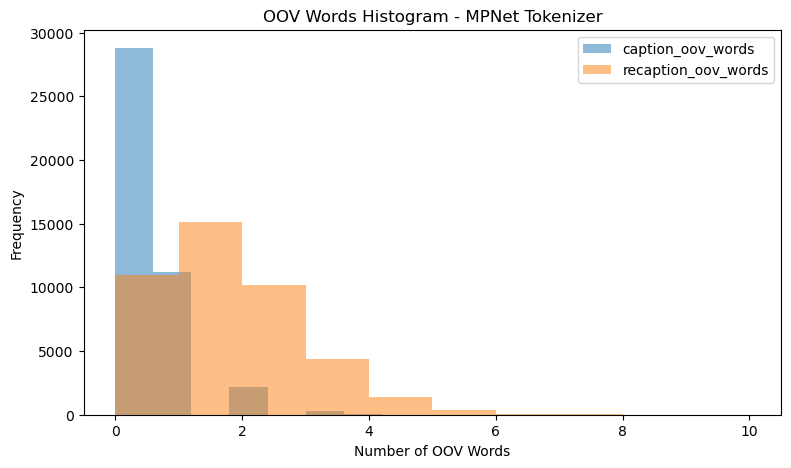

In [41]:
# Histogram of the OOV words for the captions and recaptions corpus (same plot)

plot_histogram(data_exp,['caption_oov_words','recaption_oov_words'],'OOV Words Histogram - MPNet Tokenizer','Number of OOV Words','Frequency')

In [2]:
# Histogram of the OOV words for the captions and recaptions corpus (same plot)

plot_histogram(data_exp_openai,['caption_oov_words','recaption_oov_words'],'OOV Words Histogram - OpenAI Tokenizer','Number of OOV Words','Frequency')

NameError: name 'data_exp_openai' is not defined

In [42]:
data_exp['caption_length'] = data_exp['captions'].apply(lambda x: len(x.split()))
data_exp['caption_oov_words_ratio'] = data_exp['caption_oov_words'] / data_exp['caption_length']

data_exp['recaption_length'] = data_exp['recaptions'].apply(lambda x: len(x.split()))
data_exp['recaption_oov_words_ratio'] = data_exp['recaption_oov_words'] / data_exp['recaption_length']

data_exp[['caption_oov_words_ratio', 'recaption_oov_words_ratio']].describe()

,caption_oov_words_ratio,recaption_oov_words_ratio
count,42500.000000,42500.000000
mean,0.030617,0.103267
std,0.049828,0.090813
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.086957
75%,0.071429,0.153846
max,0.400000,0.800000


In [43]:
data_exp_openai['caption_length'] = data_exp_openai['captions'].apply(lambda x: len(x.split()))
data_exp_openai['caption_oov_words_ratio'] = data_exp_openai['caption_oov_words'] / data_exp_openai['caption_length']

data_exp_openai['recaption_length'] = data_exp_openai['recaptions'].apply(lambda x: len(x.split()))
data_exp_openai['recaption_oov_words_ratio'] = data_exp_openai['recaption_oov_words'] / data_exp_openai['recaption_length']

data_exp_openai[['caption_oov_words_ratio', 'recaption_oov_words_ratio']].describe()

,caption_oov_words_ratio,recaption_oov_words_ratio
count,42500.000000,42500.000000
mean,0.187089,0.363248
std,0.104447,0.134031
min,0.000000,0.000000
25%,0.100000,0.272727
50%,0.181818,0.357143
75%,0.250000,0.454545
max,0.700000,1.000000


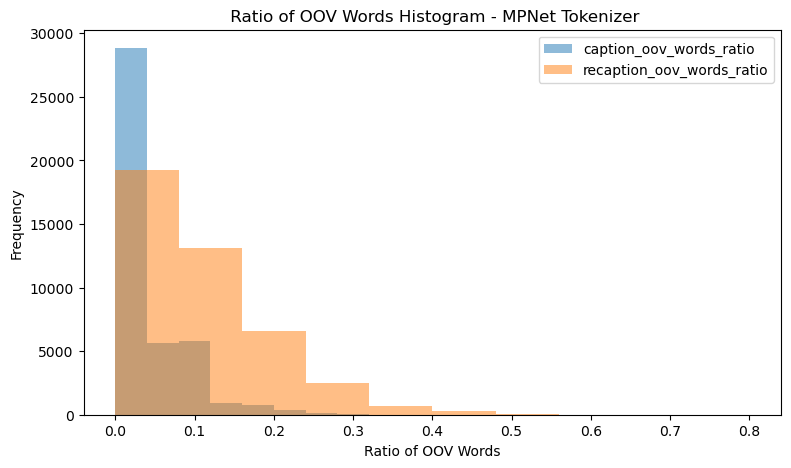

In [44]:
plot_histogram(data_exp,['caption_oov_words_ratio','recaption_oov_words_ratio'],' Ratio of OOV Words Histogram - MPNet Tokenizer','Ratio of OOV Words','Frequency')

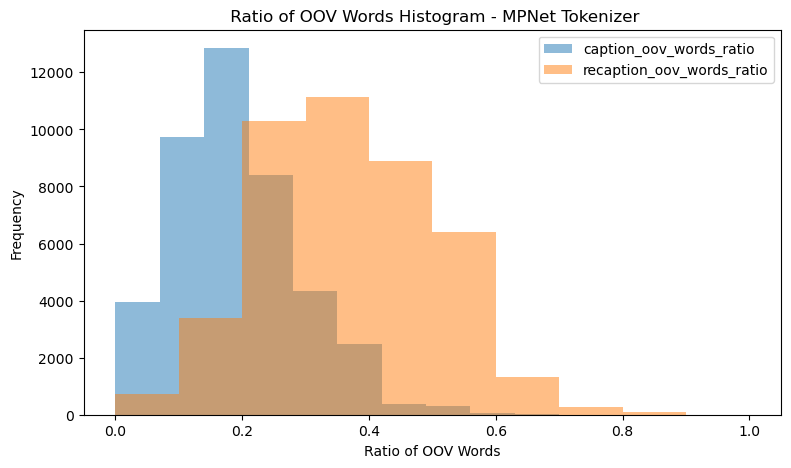

In [45]:
plot_histogram(data_exp_openai,['caption_oov_words_ratio','recaption_oov_words_ratio'],' Ratio of OOV Words Histogram - MPNet Tokenizer','Ratio of OOV Words','Frequency')

In [46]:
# Show recaptions examples with most OOV words
highest_oov_recaptions = data_exp[['recaptions','recaption_oov_words']].sort_values(by='recaption_oov_words', ascending=False).head(10)
highest_oov_recaptions

,recaptions,recaption_oov_words
25451,A wintry set of scenes filled with snowdriftin...,10
35244,A late night adventurer glides effortlessly up...,10
8329,A car winds its way through scorching sand dun...,9
35499,A group unwinds amidst the warmth of a burning...,9
39195,Un billet dune course nautique avec plusieurs ...,9
25359,A cute feline naps on a cozy beanbag then hila...,8
21264,Musicians donning cowboy hats grace the stage ...,8
9796,A tiny cherub nestled merrily within a comfy p...,8
36614,A school of shimmering fish glides amidst wave...,8
312,A tiny tot licks and slobbers over a toweldeck...,8


In [47]:
tokenizer.tokenize(highest_oov_recaptions['recaptions'].values[0])

['a',
 'win',
 '##try',
 'set',
 'of',
 'scenes',
 'filled',
 'with',
 'snow',
 '##dr',
 '##if',
 '##ting',
 'heavily',
 '##car',
 '##pet',
 '##ed',
 'cobb',
 '##led',
 'roads',
 'lit',
 'up',
 'by',
 'a',
 'charming',
 'collection',
 'of',
 'diverse',
 'residents',
 'o',
 '##cc',
 '##lus',
 '##ive',
 '##lo',
 '##oki',
 '##ng',
 'residences',
 'parallel',
 '##ed',
 'with',
 'ob',
 '##st',
 '##ru',
 '##cting',
 'driveway',
 '##s',
 'fence',
 '##d',
 'up',
 'by',
 'contrasting',
 'eccentric',
 'winter',
 '##cha',
 '##rio',
 '##t',
 'bars',
 'surrounded']

In [48]:
# Create a dicttionary that stores the number of times each OOV word appears in the captions
oov_words_captions = Counter()
for _,row in tqdm(data_exp.iterrows(), total=len(data_exp)):
    for word in row['captions'].split():
        if oov_metric.is_oov(word):
            oov_words_captions[word] += 1

print("Number of OOV words in captions: ", len(oov_words_captions))
# Print most frequent
print(oov_words_captions.most_common(10))

  0%|          | 0/42500 [00:00<?, ?it/s]

Number of OOV words in captions:  4196
[('toddler', 457), ('swims', 236), ('skis', 198), ('pans', 174), ('surfboard', 147), ('crawls', 126), ('skateboard', 116), ('bib', 111), ('bathtub', 110), ('onlookers', 108)]


In [18]:
# Get the tokens for the 10 most common OOV words in the captions in a dictionary
oov_words = oov_words_captions.most_common(20)
oov_tokens = {}
for oov_word, _ in tqdm(oov_words):
    tokens = tokenizer.tokenize(oov_word)
    if len(tokens) > 1:
        tokens = [token for token in tokens if token not in ['[UNK]', '[PAD]']]
    if len(tokens) > 0:
        oov_tokens[oov_word] = tokens
oov_tokens

  0%|          | 0/20 [00:00<?, ?it/s]

{'toddler': ['todd', '##ler'],
 'swims': ['swim', '##s'],
 'skis': ['ski', '##s'],
 'pans': ['pan', '##s'],
 'surfboard': ['surf', '##board'],
 'crawls': ['crawl', '##s'],
 'skateboard': ['skate', '##board'],
 'bib': ['bi', '##b'],
 'bathtub': ['bath', '##tub'],
 'onlookers': ['on', '##lo', '##oke', '##rs'],
 'skates': ['skate', '##s'],
 'claps': ['clap', '##s'],
 'crib': ['cr', '##ib'],
 'trampoline': ['tram', '##pol', '##ine'],
 'kayak': ['kay', '##ak'],
 'bikers': ['biker', '##s'],
 'cheerleaders': ['cheer', '##leader', '##s'],
 'someones': ['someone', '##s'],
 'bounces': ['bounce', '##s'],
 'chews': ['chew', '##s']}

In [49]:
# Create a dicttionary that stores the number of times each OOV word appears in the recaptions
oov_words_recaptions = Counter()
for _,row in tqdm(data_exp.iterrows(), total=len(data_exp)):
    for word in row['recaptions'].split():
        if oov_metric.is_oov(word):
            oov_words_recaptions[word] += 1

print("Number of OOV words in captions: ", len(oov_words_recaptions))
# Print most frequent
print(oov_words_recaptions.most_common(10))

  0%|          | 0/42500 [00:00<?, ?it/s]

Number of OOV words in captions:  11274
[('glides', 913), ('joyfully', 830), ('navigates', 744), ('toddler', 621), ('bustling', 522), ('energetically', 447), ('feline', 415), ('joyful', 354), ('onlookers', 310), ('donning', 290)]


In [50]:
# Get the tokens for the 10 most common OOV words in the captions in a dictionary
oov_words_re = oov_words_recaptions.most_common(20)
oov_tokens_re = {}
for oov_word, _ in tqdm(oov_words_re):
    tokens = tokenizer.tokenize(oov_word)
    if len(tokens) > 1:
        tokens = [token for token in tokens if token not in ['[UNK]', '[PAD]']]
    if len(tokens) > 0:
        oov_tokens_re[oov_word] = tokens
oov_tokens_re

  0%|          | 0/20 [00:00<?, ?it/s]

{'glides': ['glide', '##s'],
 'joyfully': ['joy', '##fully'],
 'navigates': ['navigate', '##s'],
 'toddler': ['todd', '##ler'],
 'bustling': ['bust', '##ling'],
 'energetically': ['energetic', '##ally'],
 'feline': ['fe', '##line'],
 'joyful': ['joy', '##ful'],
 'onlookers': ['on', '##lo', '##oke', '##rs'],
 'donning': ['don', '##ning'],
 'mesmerizing': ['me', '##sm', '##eri', '##zing'],
 'leisurely': ['leisure', '##ly'],
 'navigating': ['na', '##vi', '##gating'],
 'skillfully': ['skill', '##fully'],
 'interacts': ['interact', '##s'],
 'captivating': ['capt', '##ivating'],
 'cascading': ['cas', '##ca', '##ding'],
 'youngster': ['young', '##ster'],
 'festive': ['fest', '##ive'],
 'tranquil': ['tran', '##quil']}

In [51]:
# Get the recaptions with most OOV words and compute cosine similarity to the original caption

cosine_sim_metric = CosineSimilarity(model, tokenizer, device)

for _,row in data_exp.sort_values(by='caption_oov_words', ascending=False).head(10).iterrows():
    print(f"Original caption: {row['captions']}")
    print(f"Recaption: {row['recaptions']}")
    print(f"Cosine similarity: {cosine_sim_metric.get_metric([row['captions']], [row['recaptions']])[0][0]}")
    print()

Original caption: A yellowed headed parakeet with an olive greengrey body is chirping up past wooden poles on a stoop while orange plastic chains hang in the foreground
Recaption: A colorful bird perches and creates sounds amongst tall wooden poles and bright orange chains in the foreground
Cosine similarity: 0.6839526891708374

Original caption: Yellow Iguana is eating crickets out of a bowel with crickets and strawberries
Recaption: A vibrant Iguana savors snacks from a bowled banquet of crickets and strawberries
Cosine similarity: 0.7721712589263916

Original caption: A beagle licks a golden retriever on the body while The golden retriever wags his tail
Recaption: A friendly beagle loves to groom a cheerful golden retriever by licking its fur and making it wag its happy tail
Cosine similarity: 0.7730629444122314

Original caption: A doctor and a nurse adjust and stead a squirming baby thats inside an incubator inside an ICU
Recaption: Two medical professionals working together to ca

In [23]:
cosine_sim_metric.get_metric("This is a test", "This is another test")

array([[0.90610707]], dtype=float32)

In [24]:
cosine_sim_metric_openai = CosineSimilarity("text-embedding-ada-002", tokenizer, device)

for _,row in data_exp.sort_values(by='caption_oov_words', ascending=False).head(10).iterrows():
    print(f"Original caption: {row['captions']}")
    print(f"Recaption: {row['recaptions']}")
    print(f"Cosine similarity: {cosine_sim_metric_openai.get_metric([row['captions']], [row['recaptions']])[0][0]}")
    print()

Original caption: A yellowed headed parakeet with an olive greengrey body is chirping up past wooden poles on a stoop while orange plastic chains hang in the foreground
Recaption: A colorful bird perches and creates sounds amongst tall wooden poles and bright orange chains in the foreground
Using the first text in the list.
Using the first text in the list.
Cosine similarity: 0.9351926551293945

Original caption: Yellow Iguana is eating crickets out of a bowel with crickets and strawberries
Recaption: A vibrant Iguana savors snacks from a bowled banquet of crickets and strawberries
Using the first text in the list.
Using the first text in the list.
Cosine similarity: 0.9604398787825085

Original caption: A beagle licks a golden retriever on the body while The golden retriever wags his tail
Recaption: A friendly beagle loves to groom a cheerful golden retriever by licking its fur and making it wag its happy tail
Using the first text in the list.
Using the first text in the list.
Cosine 

In [25]:
df = data_exp.sort_values(by='caption_oov_words', ascending=False).head(100)
df['cosine_sim_mpnet'] = df.progress_apply(lambda row: cosine_sim_metric.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)
# df['cosine_sim_openai'] = df.progress_apply(lambda row: cosine_sim_metric_openai.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)

df

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,filename,url,mem_score,alpha,audio_description,captions,action_labels,actions,responses,recaptions,total_used_tokens,caption_oov_words,recaption_oov_words,caption_length,caption_oov_words_ratio,recaption_length,recaption_oov_words_ratio,cosine_sim_mpnet,cosine_sim_openai
34688,whistling_flickr-4-1-4-3-0-7-4-5-4541430745_74...,https://data.csail.mit.edu/soundnet/actions3/w...,0.859782,-0.001601,a parakeet with a yellow head and orange spot ...,A yellowed headed parakeet with an olive green...,"[whistling, sing, blowing, standing]","whistling, sing, blowing, standing",[{'id': 'chatcmpl-7KEsD8XHCFgWtwz2j23yy9Lqsprh...,A colorful bird perches and creates sounds amo...,1898,6,2,26,0.230769,18,0.111111,0.683953,0.935193
9070,eating_flickr-4-0-0-2-8-6-9-6-3140028696_6.mp4,https://data.csail.mit.edu/soundnet/actions3/e...,0.956170,-0.000442,we have what looks like a bearded dragon havin...,Yellow Iguana is eating crickets out of a bowe...,"[eating, sitting, attacking, feeding]","eating, sitting, attacking, feeding",[{'id': 'chatcmpl-7JsfxqHcgQm6WSgGRX7Wh5N49Irr...,A vibrant Iguana savors snacks from a bowled b...,1875,5,4,13,0.384615,13,0.307692,0.772171,0.960467
37995,licking_flickr-5-4-1-5-0-9-8-6-2554150986_83.mp4,https://data.csail.mit.edu/soundnet/actions3/l...,0.882156,-0.001528,on a wooden floor there are two small brown do...,A beagle licks a golden retriever on the body ...,"[licking, eating, washing, imitating, cleaning]","licking, eating, washing, imitating, cleaning",[{'id': 'chatcmpl-7KINpiV79VbEGlRLLnZsvfWo6TX9...,A friendly beagle loves to groom a cheerful go...,1880,5,3,16,0.312500,21,0.142857,0.773063,0.963662
7209,discussing_0-9-8-2-2-0-2-4-2509822024.mp4,https://data.csail.mit.edu/soundnet/actions3/d...,0.803126,-0.000455,in this video she possibly a new dad and a nur...,A doctor and a nurse adjust and stead a squirm...,[performing],performing,[{'id': 'chatcmpl-7Jr4hlVGcMK68hWzqIBlqh8o4LWC...,Two medical professionals working together to ...,1871,5,0,18,0.277778,21,0.000000,0.703262,0.907246
30119,talking_0-1-0-8-1-3-7-1-2701081371.mp4,https://data.csail.mit.edu/soundnet/actions3/t...,0.820418,-0.001956,someone is filming objects in their home a car...,a camera pans a room and shows a carlsberg bee...,"[sitting, filming, speaking]","sitting, filming, speaking",[{'id': 'chatcmpl-7KBp3szwndg2WPQ1lCijvt8557HH...,A video captures a room with a Carlsberg beer ...,1878,5,3,24,0.208333,18,0.166667,0.866015,0.972604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25077,slipping_2-1-8-5332948218.mp4,https://data.csail.mit.edu/soundnet/actions3/s...,0.639985,-0.000093,people are on snowboards on a mountain slope a...,There are various skiers and snowboarders on t...,"[slipping, skating, skiing, seeming]","slipping, skating, skiing, seeming",[{'id': 'chatcmpl-7K9ezYwILCvcluHWz3exj6XwODru...,Several winter sports enthusiasts glide and gr...,1871,3,1,12,0.250000,13,0.076923,0.664756,0.919034
12184,hiking_flickr-7-7-1-4-2-8-3-6-15777142836_9.mp4,https://data.csail.mit.edu/soundnet/actions3/h...,0.884792,-0.002100,outdoors we see a man dress for cold wearing s...,The man in the beanie and coat pans his selfie...,"[showing, rotating]","showing, rotating",[{'id': 'chatcmpl-7Jy54LtqpjDIA1fl5mokqQQOsgLs...,A beanieclad man pivots his front camera to re...,1838,3,2,15,0.200000,11,0.181818,0.641285,0.943491
28825,surfing_flickr-0-7-0-5-8-4-5-1-4807058451_1.mp4,https://data.csail.mit.edu/soundnet/actions3/s...,0.754383,-0.002280,this video shows someone trying to surf in the...,a man paddles a surfboard and catches a small ...,"[surfing, splashing, showing, flowing]","surfing, splashing, showing, flowing",[{'id': 'chatcmpl-7KBXjdYDavSGNXebmDPzVWvpR1Uz...,A surfer conquers the rough waters on his board,1875,3,1,11,0.272727,9,0.111111,0.545162,0.910957
37474,grilling_flickr-2-4-9-3-6-1-9-4-14024936194_35...,https://data.csail.mit.edu/soundnet/actions3/g...,0.934460,-0.000100,there is an assortment of food a

In [5]:
cosine_sim_metric = CosineSimilarity(model, tokenizer, device)
mpnet_caption_embeddings = model.encode(data_exp['captions'].values.tolist(), show_progress_bar=True, batch_size=512)
data_exp['mpnet_caption_embeddings'] = mpnet_caption_embeddings.tolist()

Batches:   0%|          | 0/84 [00:00<?, ?it/s]

In [6]:
mpnet_recaption_embeddings = model.encode(data_exp['recaptions'].values.tolist(), show_progress_bar=True, batch_size=512)
data_exp['mpnet_recaption_embeddings'] = mpnet_recaption_embeddings.tolist()
data_exp['mpnet_caption_embeddings'] = data_exp['mpnet_caption_embeddings'].apply(lambda x: np.array(x))
data_exp['mpnet_recaption_embeddings'] = data_exp['mpnet_recaption_embeddings'].apply(lambda x: np.array(x))
data_exp.head()

Batches:   0%|          | 0/84 [00:00<?, ?it/s]

,filename,url,mem_score,alpha,audio_description,captions,action_labels,actions,responses,recaptions,total_used_tokens,mpnet_caption_embeddings,mpnet_recaption_embeddings
0,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A brown hair girl with lip piercings mumbles s...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,A young woman with unique accessories murmurs ...,1876,"[0.06947324424982071, 0.0011880784295499325, 0...","[0.0609021857380867, 0.0020142793655395508, 0...."
1,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A brown hair girl that looks sad opens her mou...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,A sorrowful young woman singing while looking ...,1876,"[0.05719076842069626, -0.0015043470775708556, ...","[0.023775288835167885, -0.001201918930746615, ..."
2,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A girl with brown hair and lip rings looks awa...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,An edgy woman with unique lip accessories capt...,1876,"[0.019922267645597458, -0.02801157906651497, -...","[0.03154005482792854, -0.028144724667072296, 0..."
3,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A young woman wearing a striped shirt who has ...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,A distressed young woman with piercings looks ...,1876,"[0.030811598524451256, -0.031811684370040894, ...","[0.019427234306931496, -0.007810977753251791, ..."
4,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A girl staring at the camera with earnings on ...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,An adult female singer holds the cameras gaze ...,1876,"[0.004723286721855402, 0.044970206916332245, 0...","[-0.011054247617721558, -0.0009527725051157176..."


  0%|          | 0/8500 [00:00<?, ?it/s]

Captions for filename adult-female-singing_peeks-www_k_to_keek_2Qwueab_25.mp4:
A brown hair girl with lip piercings mumbles something then looks away
A brown hair girl that looks sad opens her mouth and says something before turning away
A girl with brown hair and lip rings looks away from the camera
A young woman wearing a striped shirt who has two piercings in her lower lip looks distressed
A girl staring at the camera with earnings on its mouth


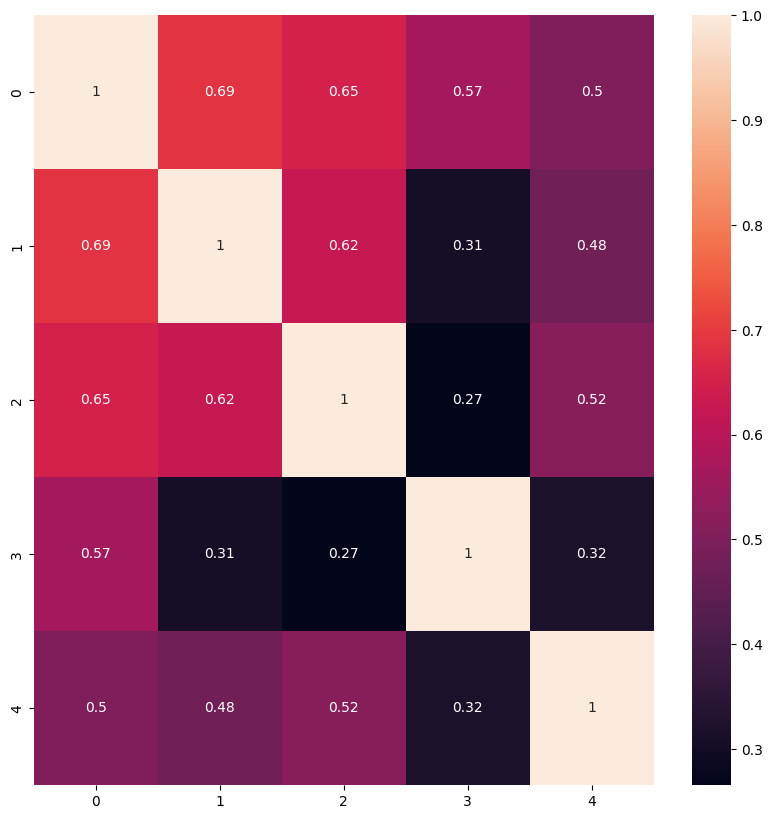

Captions for filename competing_9-0-6-9597755906.mp4:
The group of the man playing the rugby in the ground
Two teams on a football field preparing to start a play
Two peewee football teams get in formation at a game
A kids football scrimmage lines up with orange jerseys against white
Two boys football teams are in scrimmage lines on a field


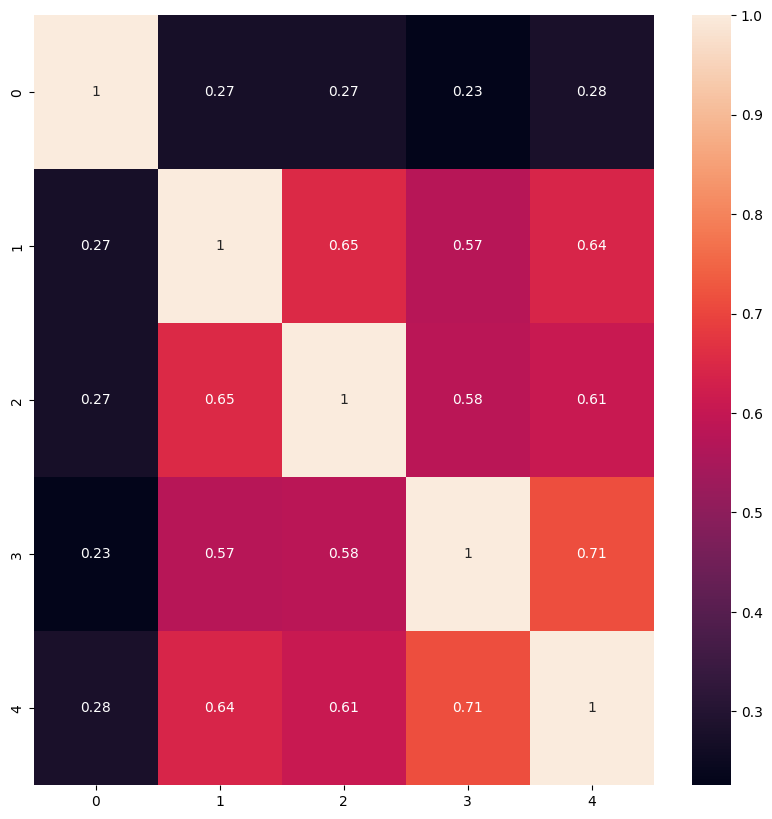

Captions for filename feeding_flickr-5-0-9-2-2-4-1-3-13950922413_1.mp4:
Man is feeding sea lions from green buckets on his house boat
a man in black grabs fish from a green bucket to feed the sea lions below
A sea lion waits patiently by a wooden dock for the person to throw it a fish
A man throws fish to seals off a small wood dock to feed them
a man feeds seals with fish from green buckets on a pier


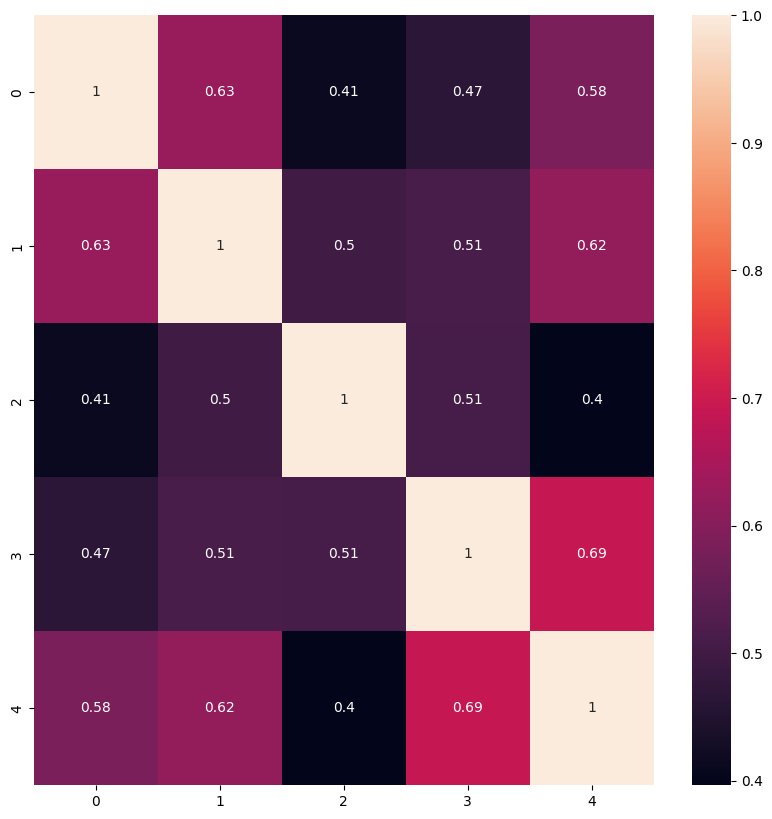

Captions for filename performing_7-1-9-3738084719.mp4:
A man in the foreground plays a guitar while a man in the background also plays a guitar
Man is standing on the stage moving and playing the guitar in front of the mic
Two men play electric guitars while another man drums in the background
There is a music show going on and you can see the two guitarists playing
The man on stage concentrates deeply as he plays his guitar


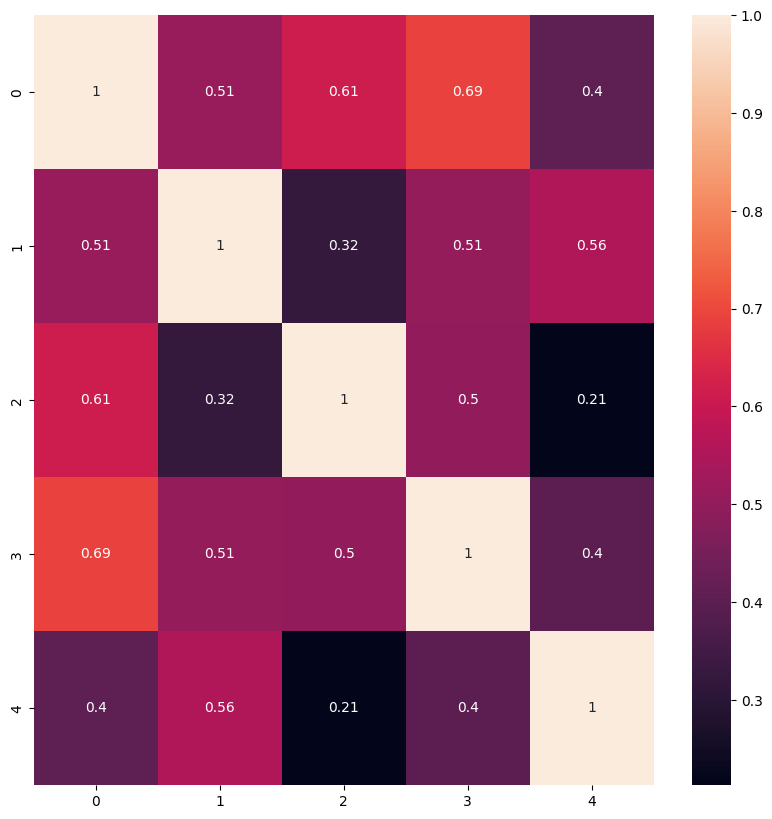

Captions for filename scratching_flickr-6-9-0-2-3-7-1-5-4369023715_5.mp4:
Who will remember what this musical artist looks like with the ski mask on
An AfricanAmerican is using deejay equipment with a light show going on behind him
A DJ grooves to the music as he stands on stage and operates his equipment
A man is playing a keyboard with headphones hanging around his neck
A dj with headphones around his neck playing music for a group


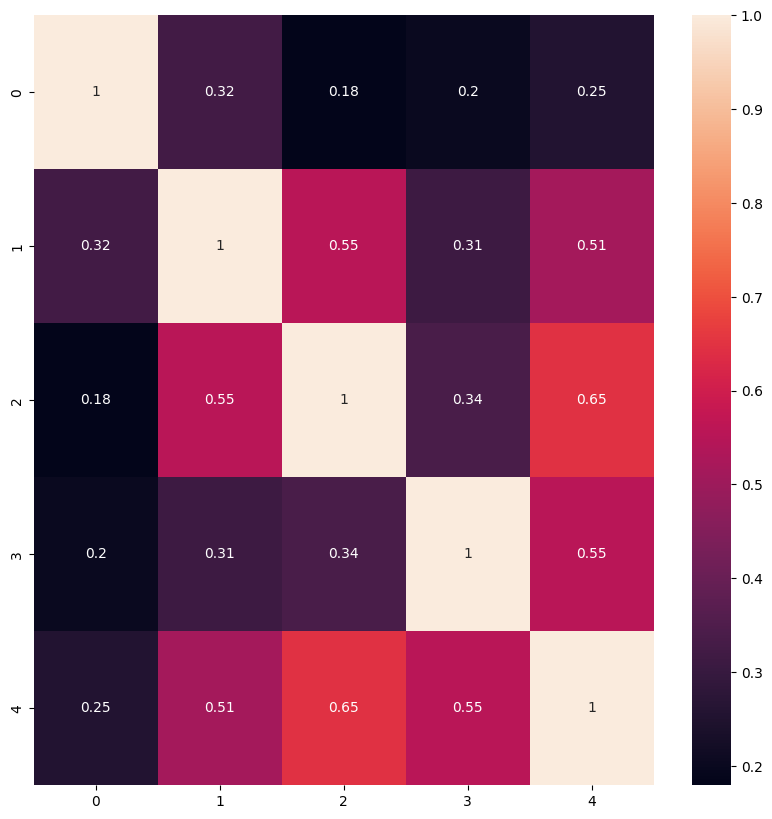

Captions for filename sliding_flickr-0-4-5-0-4-5-2-2-25204504522_8.mp4:
Children are playing on top and inside of an inflatable slide
A few children climb on top of a bouncy house and then slide down
a red ball falls down a bounce house slide while children climb up
a girl wearing black pants climbs up an inflatable slide
An inflatable house with slides a kid sliding down the slide 


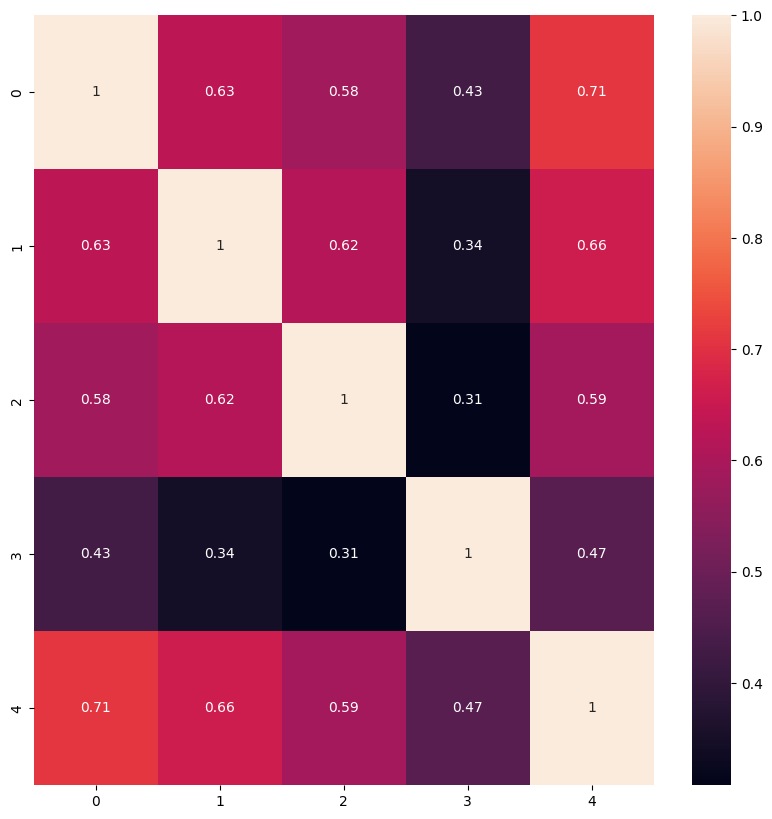

Captions for filename swinging_flickr-7-2-5-1-3-4-2-1-2472513421_1.mp4:
A young man sets to tee off at the golf outing last week
Man is waving the golf club to hit the golf ball to the sky
A man wearing a red polo initiates a driving shot on a golf course
A man on a golf course swings his club and hits the golf ball
The man in the red shirt and black hat and pants swings the golf club


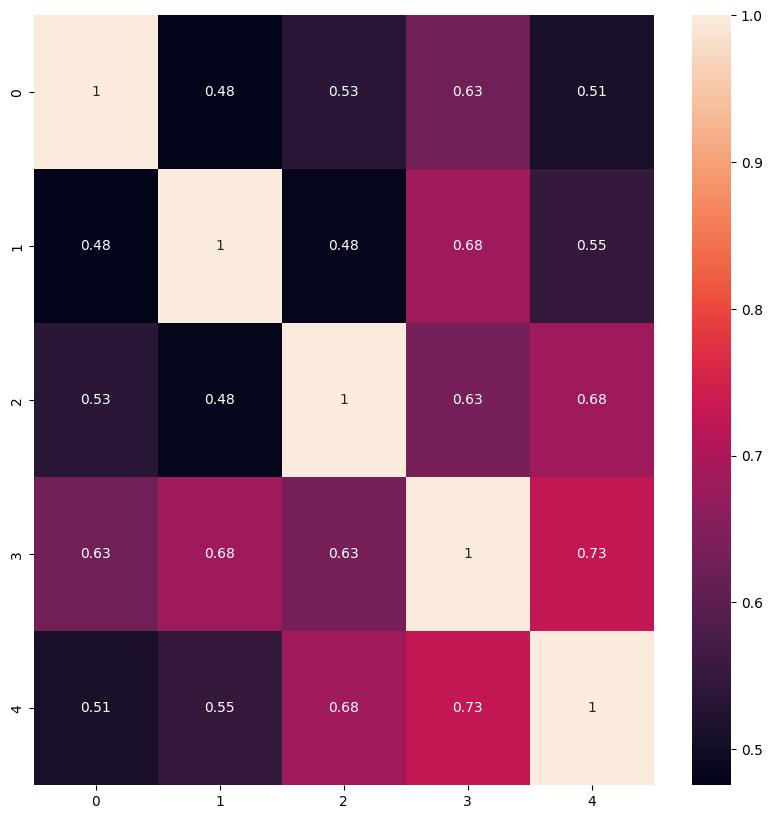

Captions for filename adult-male-singing_peeks-www_k_to_keek_vqfgeab_6.mp4:
A singer dressed in purple is singing inside a building
A boy is singing into a microphone as the camera moves from him to the curtain
A person is singing into a microphone while on a stage and being filmed
A young man is singing at a microphone before the camera pans to another microphone
A woman sings into a microphone and the camera pans behind her


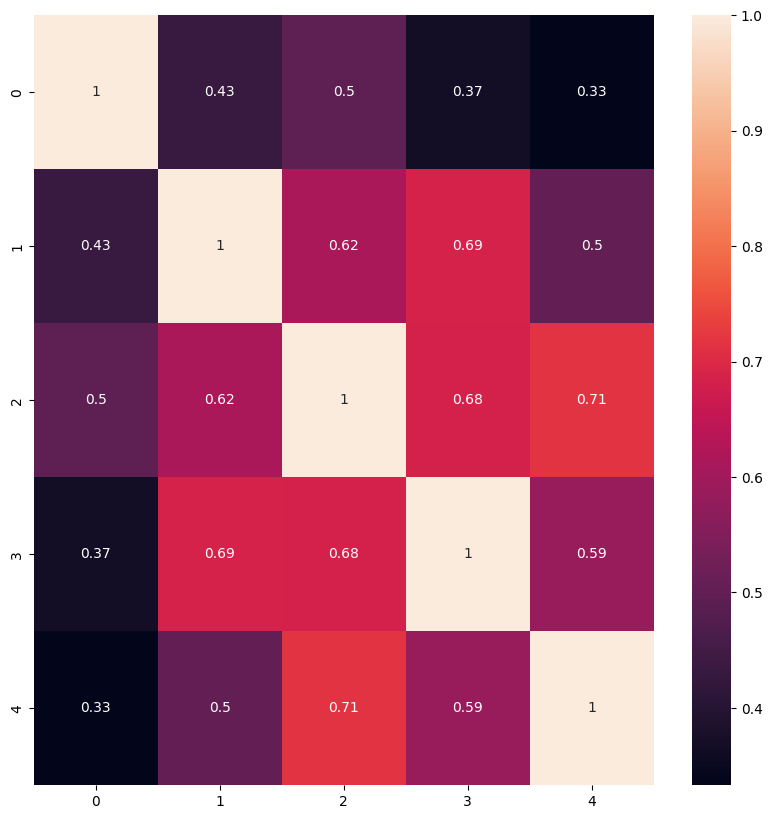

Captions for filename skating_9kyNArhUlVU_15.mp4:
Someone wearing jeans and a dark shirt riding a skateboard inside a garage
A man is standing dropping his skateboard and standing on it
A kid sets their skateboard down on the ground of the garage
a person messing around on a skateboard in the garage
A boy is getting ready to skateboard in the garage


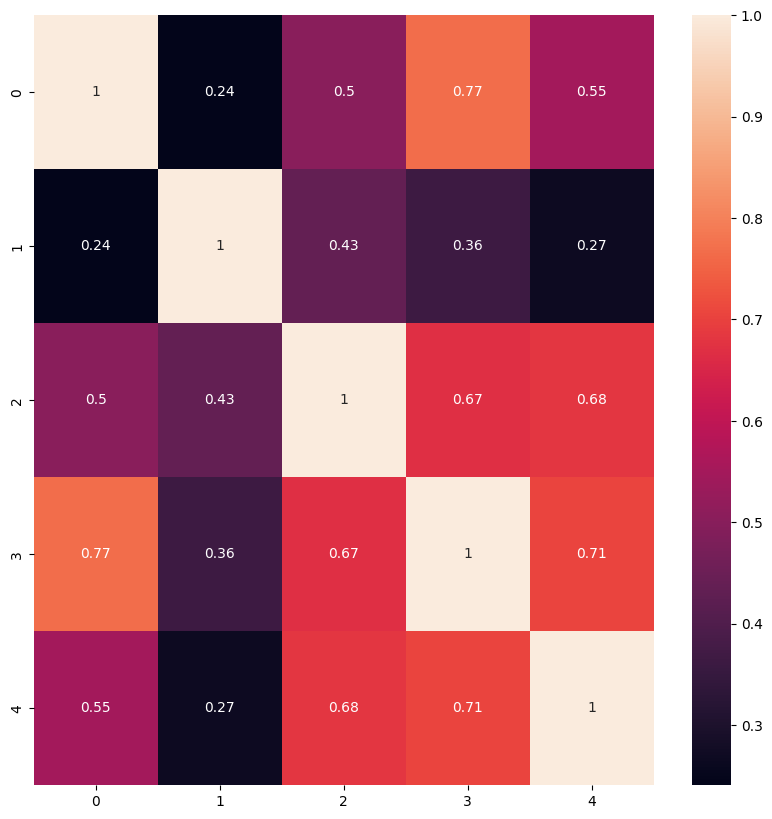

In [73]:
# Compute the mean and std cosine similarity between the captions in the same video (filename column)
data_exp['mean_emb_distance_video'] = np.zeros(len(data_exp))
data_exp['std_emb_distance_video'] = np.zeros(len(data_exp))
cosine_similarities_df = pd.DataFrame(columns=['filename', 'captions', 'cosine_similarities', 'mean_cosine_sim', 'std_cosine_sim'])
# For each unique filename detect the captions and compute the mean and std cosine similarity
for idx, filename in tqdm(enumerate(data_exp['filename'].unique()), total=len(data_exp['filename'].unique())):
    # Print the captions once every 1000 iterations
    if idx % 1000 == 0:
        print(f"Captions for filename {filename}:")
        for caption in data_exp[data_exp['filename'] == filename]['captions'].values.tolist():
            print(caption)
    # Compute the cosine similarity between all pairs of captions
    cosine_similarities_matrix = cosine_similarity(data_exp[data_exp['filename'] == filename]['mpnet_caption_embeddings'].values.tolist())
    # Plot the matrix
    if idx % 1000 == 0:
        plt.close()
        plt.figure(figsize=(10,10))
        sns.heatmap(cosine_similarities_matrix, annot=True)
        plt.show()
    # Remove diagonal and upper part of matrix (redundant)
    cosine_similarities = cosine_similarities_matrix[np.triu_indices(len(cosine_similarities_matrix), k = 1)]
    # Compute mean and std
    mean_cosine_sim = np.mean(cosine_similarities)
    std_cosine_sim = np.std(cosine_similarities)
    # Update the dataframes
    cosine_similarities_df.loc[idx, 'filename'] = filename
    cosine_similarities_df.loc[idx, 'captions'] = data_exp[data_exp['filename'] == filename]['captions'].values.tolist()
    cosine_similarities_df.loc[idx, 'cosine_similarities'] = cosine_similarities
    cosine_similarities_df.loc[idx, 'mean_cosine_sim'] = mean_cosine_sim
    cosine_similarities_df.loc[idx, 'std_cosine_sim'] = std_cosine_sim
    data_exp.loc[data_exp['filename'] == filename, 'mean_emb_distance_video'] = mean_cosine_sim
    data_exp.loc[data_exp['filename'] == filename, 'std_emb_distance_video'] = std_cosine_sim

In [80]:
data_exp.head()

,filename,url,mem_score,alpha,audio_description,captions,action_labels,actions,responses,recaptions,total_used_tokens,mpnet_caption_embeddings,mpnet_recaption_embeddings,mean_emb_distance_video,std_emb_distance_video
0,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A brown hair girl with lip piercings mumbles s...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,A young woman with unique accessories murmurs ...,1876,"[0.06947324424982071, 0.0011880784295499325, 0...","[0.0609021857380867, 0.0020142793655395508, 0....",0.4914,0.142425
1,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A brown hair girl that looks sad opens her mou...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,A sorrowful young woman singing while looking ...,1876,"[0.05719076842069626, -0.0015043470775708556, ...","[0.023775288835167885, -0.001201918930746615, ...",0.4914,0.142425
2,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A girl with brown hair and lip rings looks awa...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,An edgy woman with unique lip accessories capt...,1876,"[0.019922267645597458, -0.02801157906651497, -...","[0.03154005482792854, -0.028144724667072296, 0...",0.4914,0.142425
3,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A young woman wearing a striped shirt who has ...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,A distressed young woman with piercings looks ...,1876,"[0.030811598524451256, -0.031811684370040894, ...","[0.019427234306931496, -0.007810977753251791, ...",0.4914,0.142425
4,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,A girl staring at the camera with earnings on ...,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing",[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFoh...,An adult female singer holds the cameras gaze ...,1876,"[0.004723286721855402, 0.044970206916332245, 0...","[-0.011054247617721558, -0.0009527725051157176...",0.4914,0.142425


In [81]:
cosine_similarities_df.head()

,filename,captions,cosine_similarities,mean_cosine_sim,std_cosine_sim
0,adult-female-singing_peeks-www_k_to_keek_2Qwue...,[A brown hair girl with lip piercings mumbles ...,"[0.6853321620470282, 0.652325848767812, 0.5660...",0.4914,0.142425
1,adult-female-singing_peeks-www_k_to_keek_2Xyqe...,[A woman is standing and singing under a ceili...,"[0.4072718329277174, 0.7672861765124368, 0.433...",0.573849,0.147923
2,adult-female-singing_peeks-www_k_to_keek_2g4te...,[A person wearing a white sleeveless shirt is ...,"[0.40845361111605916, 0.6286780081133667, 0.76...",0.471137,0.159865
3,adult-female-singing_peeks-www_k_to_keek_EO30e...,[A woman leans against a red decorated wall an...,"[0.1829569292912887, 0.4164153453255597, 0.412...",0.547814,0.216943
4,adult-female-singing_peeks-www_k_to_keek_J2Rve...,[Two overweight women sway next to each other ...,"[0.4648051331357092, 0.7225607996911223, 0.570...",0.597987,0.104374


In [50]:
cosine_similarities_df.sort_values(by='mean_cosine_sim', ascending=True).iloc[(len(cosine_similarities_df)//2)-1:(len(cosine_similarities_df)//2)+1]

,filename,captions,cosine_similarities,mean_cosine_sim,std_cosine_sim
3901,rowing_flickr-4-5-9-7-1-0-5-2-22245971052_16.mp4,[Two people row in a boat along a body of wate...,"[0.6022575320460216, 0.46008593267464865, 0.70...",0.575861,0.109029
2823,lifting_flickr-5-5-9-4-5-5-1-1-3155945511_13.mp4,[The weight lifter was able to lift a large am...,"[0.5704166953249842, 0.5729580608568129, 0.550...",0.575863,0.159544


/tmp/ipykernel_643675/1436613342.py:16: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/home/imartinf/miniconda3/envs/memo/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/imartinf/miniconda3/envs/memo/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/tmp/ipykernel_643675/1436613342.py:16: UserWarning:



`distplot` is a deprecated function and will be rem

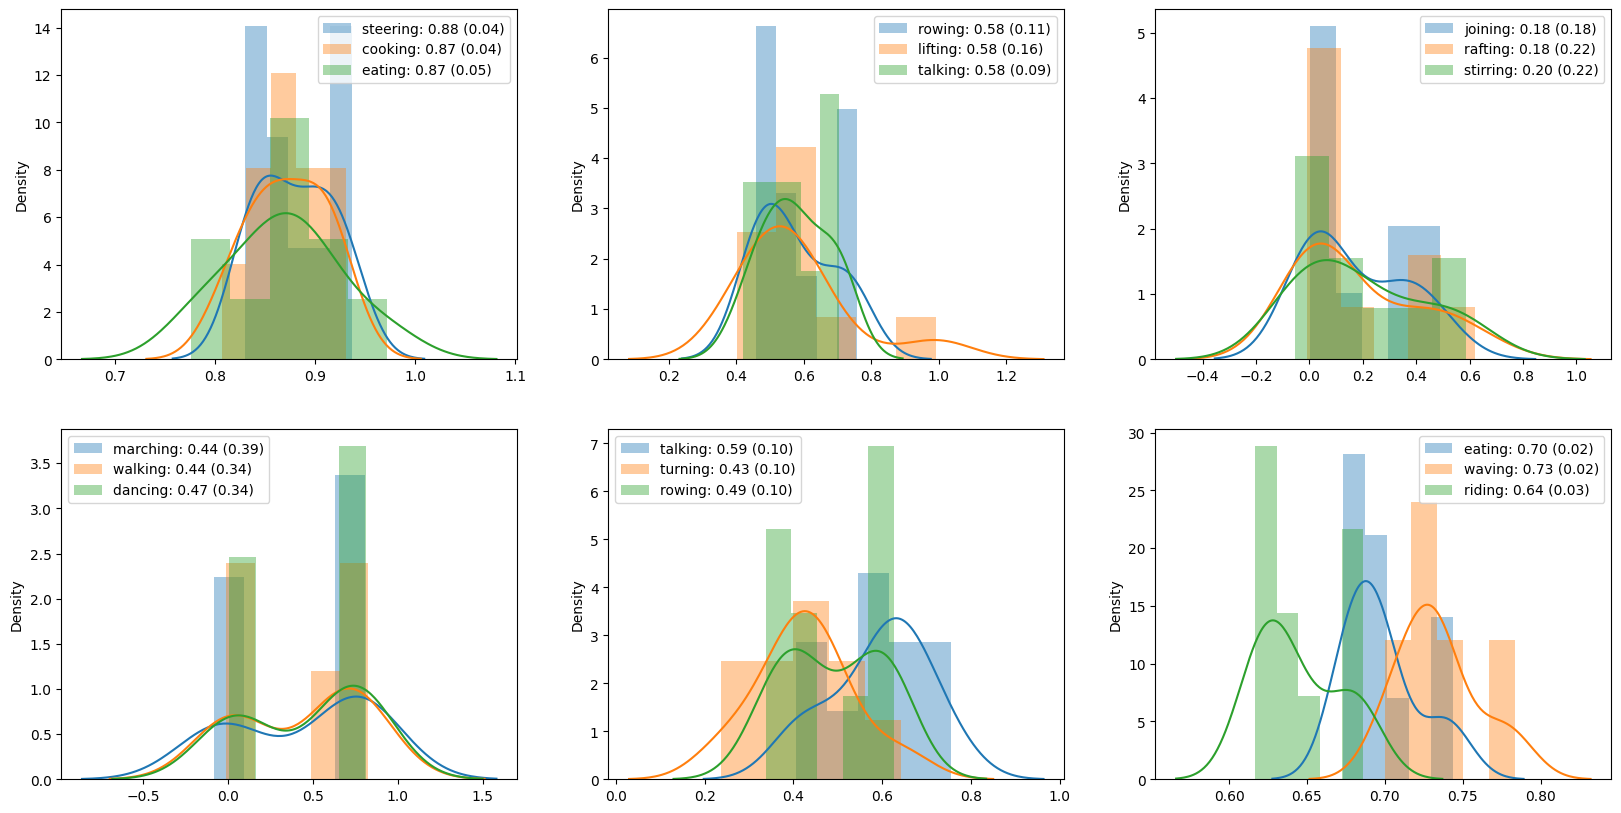

In [61]:
# Create a 3x3 grid plot where you show the distribution of the cosine similarities for the videos with the highest and lowest mean and standard deviation of the cosine similarity between the captions
# Get the videos with the highest and lowest mean cosine similarity
highest_mean_cosine_sim = cosine_similarities_df.sort_values(by='mean_cosine_sim', ascending=False).head(3)
median_mean_cosine_sim = cosine_similarities_df.sort_values(by='mean_cosine_sim', ascending=True).iloc[(len(cosine_similarities_df)//2)-1:(len(cosine_similarities_df)//2)+2]
lowest_mean_cosine_sim = cosine_similarities_df.sort_values(by='mean_cosine_sim', ascending=True).head(3)
# Get the videos with the highest and lowest std cosine similarity
highest_std_cosine_sim = cosine_similarities_df.sort_values(by='std_cosine_sim', ascending=False).head(3)
median_std_cosine_sim = cosine_similarities_df.sort_values(by='std_cosine_sim', ascending=True).iloc[(len(cosine_similarities_df)//2)-1:(len(cosine_similarities_df)//2)+2]
lowest_std_cosine_sim = cosine_similarities_df.sort_values(by='std_cosine_sim', ascending=True).head(3)


# Plot the cosine similarity distributions (mean case)
plt.close()
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for idx, row in highest_mean_cosine_sim.iterrows():
    sns.distplot(row['cosine_similarities'], bins=5, ax=axs[0, 0], label=f"{row['filename'].split('_')[0]}: {row['mean_cosine_sim']:.2f} ({row['std_cosine_sim']:.2f})")
    # Plot mean and std
    axs[0, 0].axvline(row['mean_cosine_sim'], color='red')
    axs[0, 0].axvline(row['mean_cosine_sim'] + row['std_cosine_sim'], color='green')
    axs[0, 0].axvline(row['mean_cosine_sim'] - row['std_cosine_sim'], color='green')
    axs[0, 0].legend()
for idx, row in median_mean_cosine_sim.iterrows():
    sns.distplot(row['cosine_similarities'], bins=5, ax=axs[0, 1], label=f"{row['filename'].split('_')[0]}: {row['mean_cosine_sim']:.2f} ({row['std_cosine_sim']:.2f})")
    axs[0, 0].axvline(row['mean_cosine_sim'], color='red')
    axs[0, 0].axvline(row['mean_cosine_sim'] + row['std_cosine_sim'], color='green')
    axs[0, 0].axvline(row['mean_cosine_sim'] - row['std_cosine_sim'], color='green')
    axs[0, 1].legend()
for idx, row in lowest_mean_cosine_sim.iterrows():
    sns.distplot(row['cosine_similarities'], bins=5, ax=axs[0, 2], label=f"{row['filename'].split('_')[0]}: {row['mean_cosine_sim']:.2f} ({row['std_cosine_sim']:.2f})")
    axs[0, 0].axvline(row['mean_cosine_sim'], color='red')
    axs[0, 0].axvline(row['mean_cosine_sim'] + row['std_cosine_sim'], color='green')
    axs[0, 0].axvline(row['mean_cosine_sim'] - row['std_cosine_sim'], color='green')
    axs[0, 2].legend()

for idx, row in highest_std_cosine_sim.iterrows():
    sns.distplot(row['cosine_similarities'], bins=5, ax=axs[1, 0], label=f"{row['filename'].split('_')[0]}: {row['mean_cosine_sim']:.2f} ({row['std_cosine_sim']:.2f})")
    axs[0, 0].axvline(row['mean_cosine_sim'], color='red')
    axs[0, 0].axvline(row['mean_cosine_sim'] + row['std_cosine_sim'], color='green')
    axs[0, 0].axvline(row['mean_cosine_sim'] - row['std_cosine_sim'], color='green')
    axs[1, 0].legend()
for idx, row in median_std_cosine_sim.iterrows():
    sns.distplot(row['cosine_similarities'], bins=5, ax=axs[1, 1], label=f"{row['filename'].split('_')[0]}: {row['mean_cosine_sim']:.2f} ({row['std_cosine_sim']:.2f})")
    axs[0, 0].axvline(row['mean_cosine_sim'], color='red')
    axs[0, 0].axvline(row['mean_cosine_sim'] + row['std_cosine_sim'], color='green')
    axs[0, 0].axvline(row['mean_cosine_sim'] - row['std_cosine_sim'], color='green')
    axs[1, 1].legend()
for idx, row in lowest_std_cosine_sim.iterrows():
    sns.distplot(row['cosine_similarities'], bins=5, ax=axs[1, 2], label=f"{row['filename'].split('_')[0]}: {row['mean_cosine_sim']:.2f} ({row['std_cosine_sim']:.2f})")
    axs[0, 0].axvline(row['mean_cosine_sim'], color='red')
    axs[0, 0].axvline(row['mean_cosine_sim'] + row['std_cosine_sim'], color='green')
    axs[0, 0].axvline(row['mean_cosine_sim'] - row['std_cosine_sim'], color='green')
    axs[1, 2].legend()

plt.show()



In [97]:
# Repeat with boxplots. Use plotly
# Plot the cosine similarity distributions (mean case)
plt.close()
fig = go.Figure()
for idx, row in highest_mean_cosine_sim.iterrows():
    fig.add_trace(go.Box(y=row['cosine_similarities'], name=f"{row['filename'].split('_')[0]}: {row['mean_cosine_sim']:.2f} ({row['std_cosine_sim']:.2f})"))
for idx, row in median_mean_cosine_sim.iterrows():
    fig.add_trace(go.Box(y=row['cosine_similarities'], name=f"{row['filename'].split('_')[0]}: {row['mean_cosine_sim']:.2f} ({row['std_cosine_sim']:.2f})"))
for idx, row in lowest_mean_cosine_sim.iterrows():
    fig.add_trace(go.Box(y=row['cosine_similarities'], name=f"{row['filename'].split('_')[0]}: {row['mean_cosine_sim']:.2f} ({row['std_cosine_sim']:.2f})"))
fig.update_layout(
    title="Cosine similarity between captions for videos with highest and lowest mean cosine similarity",
    yaxis_title="Cosine similarity",
    xaxis_title="Video",
    legend_title="Video"
)
fig.show()

In [65]:
# Show captions with lowest mean and highest std cosine similarity
print("Captions with lowest mean cosine similarity:")
for idx, row in lowest_mean_cosine_sim.iterrows():
    print(f"Filename: {row['filename']}")
    for caption in row['captions']:
        print(f"Caption: {caption}")
    print(f"Mean cosine similarity: {row['mean_cosine_sim']}")
    print(f"Std cosine similarity: {row['std_cosine_sim']}")
    print()

print("Captions with highest std cosine similarity:")
for idx, row in highest_std_cosine_sim.iterrows():
    print(f"Filename: {row['filename']}")
    for caption in row['captions']:
        print(f"Caption: {caption}")
    print(f"Mean cosine similarity: {row['mean_cosine_sim']}")
    print(f"Std cosine similarity: {row['std_cosine_sim']}")
    print()

Captions with lowest mean cosine similarity:
Filename: joining_flickr-0-0-9-6402573009_23.mp4
Caption: A street performance draws the attention of hundreds of people
Caption: A man with a red backpack stops walking and takes his bag off his shoulder
Caption: A woman with curly blonde hair takes a picture of a street performer
Caption: The people on the street take pictures of the urban setting
Caption: A curly blonde lady with a green scarf and black jacket
Mean cosine similarity: 0.17501832831434164
Std cosine similarity: 0.17812120076920668

Filename: rafting_flickr-2-8-8-2-1-5-4-1-22728821541_1.mp4
Caption: lot of interesting content that we all want to see and know more
Caption: two men wearing hats sit inside a red kayak floating on the water
Caption: two people in a boat going downstream towards rapids
Caption: a couple guys slowly floating down the river in a raft
Caption: A guy with a baseball cap a white shirt and a dark backpack
Mean cosine similarity: 0.1843602796500296
Std 

In [98]:
# Compute and store in the dataframe the mean distance between each caption and the other captions in the same video
# Compute also the z-score between this value and the distribution for the whole video, for each caption
data_exp['mean_emb_distance'] = np.zeros(len(data_exp))
data_exp['caption_z_score'] = np.zeros(len(data_exp))
for idx, row in tqdm(data_exp.iterrows(), total=len(data_exp)):
    # Get the embeddings of the other captions in the same video
    other_captions_embeddings = data_exp[(data_exp['filename'] == row['filename']) & (data_exp['captions'] != row['captions'])]['mpnet_caption_embeddings'].values.tolist()
    # Compute the cosine similarity between the caption and the other captions
    cosine_similarities = cosine_similarity([row['mpnet_caption_embeddings']], other_captions_embeddings)[0]
    # Compute the mean cosine similarity
    mean_cosine_sim = np.mean(cosine_similarities)
    mean_cosine_sim_video = cosine_similarities_df[cosine_similarities_df['filename'] == row['filename']]['mean_cosine_sim'].values[0]
    std_cosine_sim_video = cosine_similarities_df[cosine_similarities_df['filename'] == row['filename']]['std_cosine_sim'].values[0]
    data_exp.loc[idx, 'caption_z_score'] = z_score(mean_cosine_sim, mean_cosine_sim_video, std_cosine_sim_video)
    if idx % 10000 == 0:
        print(f"Filename: {row['filename']}")
        print(f"Mean cosine similarity: {mean_cosine_sim_video}")
        print(f"Std cosine similarity: {std_cosine_sim_video}")
        print(f"Caption: {row['captions']}")
        print(f"Caption cosine similarity: {mean_cosine_sim}")
        print(f"Caption z-score: {data_exp.loc[idx, 'caption_z_score']}")
    # Update the dataframe
    data_exp.loc[idx, 'mean_emb_distance'] = mean_cosine_sim

data_exp.head()


  0%|          | 0/42500 [00:00<?, ?it/s]

Filename: adult-female-singing_peeks-www_k_to_keek_2Qwueab_25.mp4
Mean cosine similarity: 0.49140025563528117
Std cosine similarity: 0.14242484479996148
Caption: A brown hair girl with lip piercings mumbles something then looks away
Caption cosine similarity: 0.6017589407844399
Caption z-score: 0.7748555759647112
Filename: feeding_flickr-5-0-9-2-2-4-1-3-13950922413_1.mp4
Mean cosine similarity: 0.5319665899433538
Std cosine similarity: 0.09130733808792237
Caption: Man is feeding sea lions from green buckets on his house boat
Caption cosine similarity: 0.522941318683964
Caption z-score: -0.09884497181047054
Filename: scratching_flickr-6-9-0-2-3-7-1-5-4369023715_5.mp4
Mean cosine similarity: 0.38751168544947345
Std cosine similarity: 0.1575365638361006
Caption: Who will remember what this musical artist looks like with the ski mask on
Caption cosine similarity: 0.23847990527984417
Caption z-score: -0.9460139064901809
Filename: swinging_flickr-7-2-5-1-3-4-2-1-2472513421_1.mp4
Mean cosine 

,filename,url,mem_score,alpha,audio_description,captions,action_labels,actions,responses,recaptions,total_used_tokens,mpnet_caption_embeddings,mpnet_recaption_embeddings,mean_emb_distance_video,std_emb_distance_video,mean_emb_distance,caption_z_score
0,adult-female-singing_peeks-www_k_to_keek_2Qwueab_25.mp4,https://data.csail.mit.edu/soundnet/actions3/adult+female+singing/peeks-www_k_to_keek_2Qwueab_25.mp4,0.989151,-0.000387,indoors you see a woman with red hair held up in a bun and piercings on either side of her lip she's looking sad,A brown hair girl with lip piercings mumbles something then looks away,"[holding, looking, adult+female+singing, singing]","holding, looking, adult female singing, singing","[{'id': 'chatcmpl-7JjS3S4mrGA2Pfb5N399lR6LxFohN', 'object': 'chat.completion', 'created': 1684937303, 'model': 'gpt-35-turbo', 'choices': [{'index': 0, 'finish_reason': 'stop', 'message': {'role': 'assistant', 'content': 'A young woman with unique accessories murmurs before turning her gaze elsewhere.'}}], 'usage': {'completion_tokens': 14, 'prompt_tokens': 360, 'total_tokens': 374}}, {'id': 'chatcmpl-7JjS4F134jMtKTLCqMPQ2xugHYt0a', 'object': 'chat.completion', 'created': 1684937304, 'model': 'gpt-35-turbo', 'choices': [{'index': 0, 'finish_reason': 'stop', 'message': {'role': 'assistant', 'content': 'A sorrowful young woman singing while looking away with her mouth open.'}}], 'usage': {'completion_tokens': 14, 'prompt_tokens': 361, 'total_tokens': 375}}, {'id': 'chatcmpl-7JjS4qS9g5Rc7S6dSLp4A8MtJLePJ', 'object': 'chat.completion', 'created': 1684937304, 'model': 'gpt-35-turbo', 'choices': [{'index': 0, 'finish_reason': 'stop', 'message': {'role': 'assistant', 'content': 'An edgy woman with unique lip accessories captures attention singing towards something unseen.'}}], 'usage': {'completion_tokens': 15, 'prompt_tokens': 358, 'total_tokens': 373}}, {'id': 'chatcmpl-7JjS5QmKCp4s0QcBh3XrDj4Pa2v9I', 'object': 'chat.completion', 'created': 1684937305, 'model': 'gpt-35-turbo', 'choices': [{'index': 0, 'finish_reason': 'stop', 'message': {'role': 'assistant', 'content': 'A distressed young woman with piercings looks somber while singing.'}}], 'usage': {'completion_tokens': 14, 'prompt_tokens': 366, 'total_tokens': 380}}, {'id': 'chatcmpl-7JjS5WlIBEf4mZJ7Tlv79ysD1NhfN', 'object': 'chat.completion', 'created': 1684937305, 'model': 'gpt-35-turbo', 'choices': [{'index': 0, 'finish_reason': 'stop', 'message': {'role': 'assistant', 'content': ""An adult female singer holds the camera's gaze with earrings adorning her lips while singing.""}}], 'usage': {'completion_tokens': 18, 'prompt_tokens': 356, 'total_tokens': 374}}]",A young woman with unique accessories murmurs before turning her gaze elsewhere,1876,"[0.06947324424982071, 0.0011880784295499325, 0.009489204734563828, -0.000726985395886004, 0.04288337752223015, 0.03692407160997391, 0.03661710396409035, 0.024610091000795364, -0.024676544591784477, 0.016155250370502472, -0.03413655236363411, 0.028403321281075478, -0.010773011483252048, -0.024722669273614883, -0.0016580399824306369, 0.005990799982100725, -0.016045914962887764, -0.004993823356926441, 0.06086486950516701, -0.01838207058608532, 0.029094260185956955, 0.03592555224895477, -0.05308324471116066, 0.09055318683385849, -0.05978414788842201, -0.02359587885439396, -0.010780398733913898, 0.06067328155040741, -0.04630272835493088, 0.024684738367795944, -0.03145516291260719, -0.007173336576670408, -0.06018255650997162, -0.06428076326847076, 1.3209961480242782e-06, 0.031447187066078186, -0.021226130425930023, 0.0035205574240535498, -0.07248475402593613, -0.012518643401563168, 0.012380117550492287, -0.043522000312805176, 0.028051523491740227, 0.01087141316384077, -0.018715642392635345, 0.04683585837483406, 0.042237184941768646, 0.011602838523685932, 0.011197829619050026, -0.06983084231615067, 0.011373571120202541, -0.006535818800330162, -0.011701338924467564, -0.016149811446666718, 0.12723729014396667, -0.05056805536150932, -0.01815077

In [99]:
# Print the captions ith the lowest z-score along with the other captions in the same video
highest_z_score = data_exp.sort_values(by='caption_z_score', ascending=True).head(10)
for idx, row in highest_z_score.iterrows():
    print(f"Filename: {row['filename']}")
    print(f"Mean cosine similarity: {row['mean_emb_distance_video']}")
    print(f"Std cosine similarity: {row['std_emb_distance_video']}")
    print(f"Caption: {row['captions']}")
    print(f"Caption z-score: {row['caption_z_score']}")
    print()
    print("Other captions in the same video:")
    for caption in data_exp[data_exp['filename'] == row['filename']]['captions'].values.tolist():
        print(caption)
    print()

Filename: biking_flickr-8-4-2-1-1-2-8-0-4984211280_14.mp4
Mean cosine similarity: 0.6368500202639398
Std cosine similarity: 0.20026325524806488
Caption: A man rides his bike in water without protective equipment
Caption z-score: -1.2200102710096652

Other captions in the same video:
A young boy is riding on his bicycle through the stream
A man rides his bike in water without protective equipment
A young boy rides his mountain bike through a rocky stream bed
A young boy is riding his bike through a small creek with many rocks
The boy rides his bike skillfully through the rocky stream

Filename: walking_flickr-4-2-3-7-2-4-0-4-11042372404_4.mp4
Mean cosine similarity: 0.7405386459640784
Std cosine similarity: 0.21433733837889019
Caption: A dog with a vest on is looking at a tree and then walking
Caption z-score: -1.2197267089008352

Other captions in the same video:
A dog with a vest on is looking at a tree and then walking
A cat on a leash looks up at tree and then continues walking down

In [33]:
data_exp.sort_values(by='mpnet_mean_cosine_sim', ascending=True).head(300).to_csv('../data/processed/memento_data_recaption_low_mean_cosine_sim.csv')

In [34]:
pd.set_option('display.max_colwidth', None)
data_exp[data_exp.filename=='stirring_wc-EdwKUvcaw1wU_32.mp4'][['captions','recaptions']]

,captions,recaptions
41000,A news report reports on new balloons at the Macys Day Parade Crowds walk and watch the floats,A journalist showcases fresh balloons on the Macys Day Parade as spectators accompany the colorful floats
41001,a man and a lady walk down a very busy street with each other,A couple navigates a bustling metropolis together while holding hands and exchanging words
41002,The people are watching the Thanksgiving Day parade in the city,Spectators gather around the colorful and lively parade in the city on Thanksgiving Day featuring various drifting balloons and amusing performances
41003,People looking on as a Thanksgiving Day float is going down the street,A festive procession boasting a massive float traversing a packed streetscape dotted with enthusiast observers
41004,a man in a black jack speaks into a bluetooth earpiece,A man commands attention wearing a black jack speaking confidently into a wireless earpiece whilst walking energetically


In [34]:
data_exp['mem_score'].describe()

count    42500.000000
mean         0.801377
std          0.105019
min          0.383271
25%          0.732946
50%          0.813050
75%          0.880761
max          1.000000
Name: mem_score, dtype: float64

<Axes: >

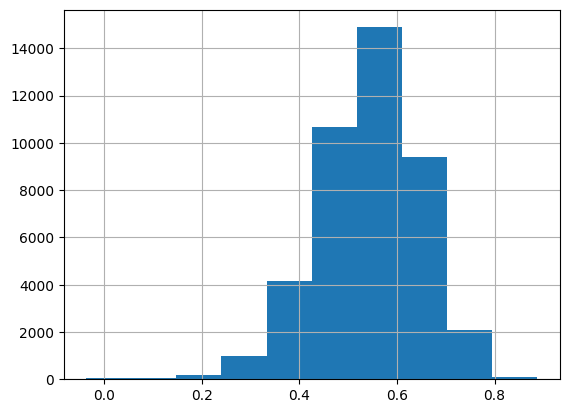

In [28]:
data_exp['mpnet_mean_cosine_sim'].hist()

<Axes: >

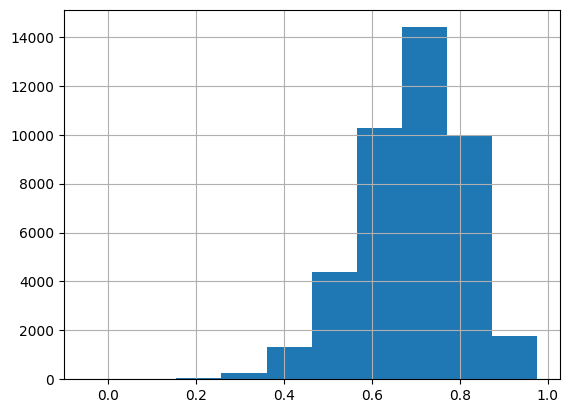

In [35]:
data_exp['mpnet_cosine_sim'].hist()

In [36]:
data_exp['mpnet_cosine_sim'].describe()

count    42500.000000
mean         0.692201
std          0.120035
min         -0.049704
25%          0.618009
50%          0.703642
75%          0.779243
max          0.975266
Name: mpnet_cosine_sim, dtype: float64

In [38]:
len(data_exp[data_exp['mpnet_cosine_sim'] < 0.5])/len(data_exp)

0.06489411764705882

In [47]:
pd.set_option('display.max_rows', None)
data_exp[data_exp['mpnet_cosine_sim'] > 0.5].sort_values(by='mpnet_cosine_sim', ascending=True)[['captions','recaptions','mpnet_cosine_sim','mpnet_mean_cosine_sim']].head(300)

,captions,recaptions,mpnet_cosine_sim,mpnet_mean_cosine_sim
26529,A group of people playing instruments in a classroom with pictures on the wall,A harmony of sounds blend in a room surrounded by mesmerizing pictures,0.500027,0.328945
13476,The baby is sitting in a rocker seat being played with,A chuckling infant happily occupies a bouncing contraption while amusedly interacting with someone,0.500042,0.632131
34957,A girl is sitting down playing a keyboard and singing,A young woman harmonizes theme music on the ivories while airily crooning,0.500084,0.514732
42290,A man in winter hat and red jacket walking down the slope of a grassy hill,A person in warm cloths amble towards the cover of grassy downtrend,0.500090,0.500751
23149,A band with a drummer and guitars play music while another sings,A musical group jamming with singer and instrumentalists amidst a snowy setting,0.500107,0.447137
23446,a woman holds a child wearing a white and yellow onesie over her knee,A woman balances a little one in colorful attireas they interact intimately,0.500117,0.405366
13127,A soccer player for the blue team scores a goal,A stunning blue team performance end with an outstanding victory from a great kick,0.500130,0.467593
15475,a woman in a white shirt and tan sweater is singing into a microphone,A poised singer captivates as she belts into a waiting microphone,0.500158,0.549103
2434,The only light in the black of night was that of a small burning fire,A blazing fire lit up the dark and someone performed a mesmerizing juggling act,0.500161,0.452282
21475,A person is playing guitar on stage and dancing next to a drum set,A musician energizes the crowd with live music and lively movements,0.500175,0.480824


In [26]:
# Edit pandas display options so that we can see the full text
pd.set_option('display.max_colwidth', None)
df[['captions','recaptions','caption_oov_words','cosine_sim_mpnet','cosine_sim_openai']].head(5)

,captions,recaptions,caption_oov_words,cosine_sim_mpnet,cosine_sim_openai
34688,A yellowed headed parakeet with an olive greengrey body is chirping up past wooden poles on a stoop while orange plastic chains hang in the foreground,A colorful bird perches and creates sounds amongst tall wooden poles and bright orange chains in the foreground,6,0.683953,0.935193
9070,Yellow Iguana is eating crickets out of a bowel with crickets and strawberries,A vibrant Iguana savors snacks from a bowled banquet of crickets and strawberries,5,0.772171,0.960467
37995,A beagle licks a golden retriever on the body while The golden retriever wags his tail,A friendly beagle loves to groom a cheerful golden retriever by licking its fur and making it wag its happy tail,5,0.773063,0.963662
7209,A doctor and a nurse adjust and stead a squirming baby thats inside an incubator inside an ICU,Two medical professionals working together to care for a fragile baby in need of attention and assistance within a specialized unit,5,0.703262,0.907246
30119,a camera pans a room and shows a carlsberg beer inflatable and then zooms to a tv screen on top of a credenza bureau,A video captures a room with a Carlsberg beer inflatable and a TV screen atop a credenza bureau,5,0.866015,0.972604


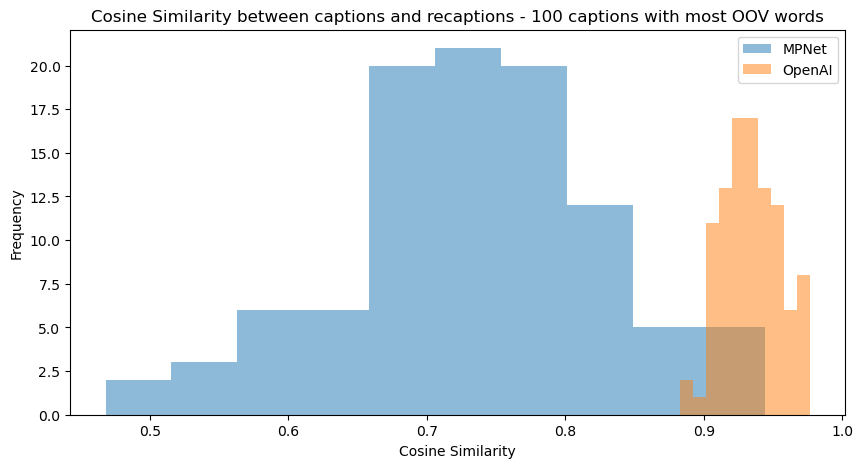

In [27]:
# Plot an overimposed histogram of the cosine similarities per MPNet and OpenAI
plt.figure(figsize=(10, 5))
plt.hist(df['cosine_sim_mpnet'], bins=10, alpha=0.5, label='MPNet')
plt.hist(df['cosine_sim_openai'], bins=10, alpha=0.5, label='OpenAI')
plt.legend(loc='upper right')
plt.title('Cosine Similarity between captions and recaptions - 100 captions with most OOV words')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [29]:
df2 = data_exp.sort_values(by='recaption_oov_words', ascending=False).head(100)
df2['cosine_sim_mpnet'] = df2.progress_apply(lambda row: cosine_sim_metric.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)
df2['cosine_sim_openai'] = df2.progress_apply(lambda row: cosine_sim_metric_openai.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)

df2[['captions','recaptions','caption_oov_words','cosine_sim_mpnet','cosine_sim_openai']].head(5)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,captions,recaptions,caption_oov_words,cosine_sim_mpnet,cosine_sim_openai
25451,Snow covered houses on a snow covered street with snow blanketed cars,A wintry set of scenes filled with snowdrifting heavilycarpeted cobbled roads lit up by a charming collection of diverse residents occlusivelooking residences paralleled with obstructing driveways fenced up by contrasting eccentric winterchariot bars surrounded,1,0.711434,0.907137
35244,a man wearing a backpack snowboards up a hill at night,A late night adventurer glides effortlessly up a snowcapped mound adorned in frontporch America cos omcmene up omypist opws7 codingdeEra eraKr eujsloopaw,1,0.460499,0.861020
8329,The view outside the windshield of a vehicle as it drives through a desert,A car winds its way through scorching sand dunes trudging through them under an sunpuzzling earth bleached without any discernible peak insight into the neverending expanses of the world also barrennes canyd sculptures watching them,0,0.566428,0.888759
35499,People are sitting around a campfire and the lady in a green sweatshirt is roasting marshmallows,A group unwinds amidst the warmth of a burning evening fire pit where a lady adorns a green sweatshirt and frosts foamy marshmallows over the brilliantly undulating and twinkling ember lights,3,0.796249,0.935788
39195,Several teams of four people each rowing down a waterway,Un billet dune course nautique avec plusieurs équipes de quatre pagayeurs glissant sur une voie navigable,0,0.276925,0.869016


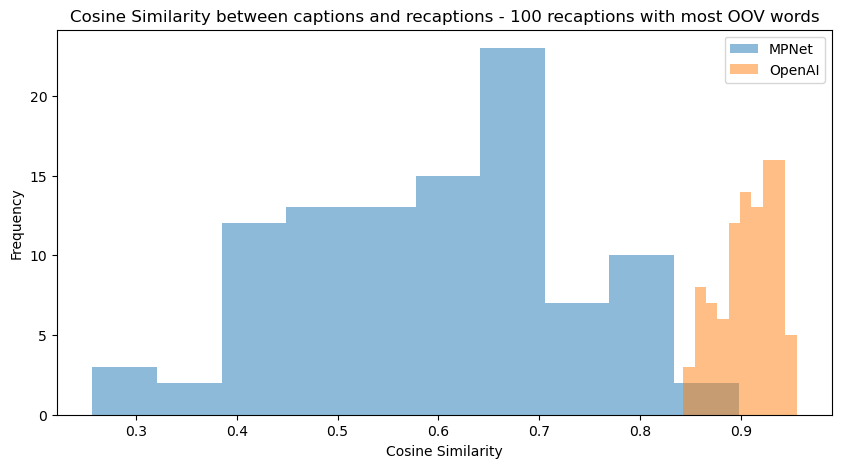

In [30]:
# Plot an overimposed histogram of the cosine similarities per MPNet and OpenAI
plt.figure(figsize=(10, 5))
plt.hist(df2['cosine_sim_mpnet'], bins=10, alpha=0.5, label='MPNet')
plt.hist(df2['cosine_sim_openai'], bins=10, alpha=0.5, label='OpenAI')
plt.legend(loc='upper right')
plt.title('Cosine Similarity between captions and recaptions - 100 recaptions with most OOV words')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [33]:
df3 = data_exp.sample(5000, random_state=42)
df3['cosine_sim_mpnet'] = df3.progress_apply(lambda row: cosine_sim_metric.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)
df3['cosine_sim_openai'] = df3.progress_apply(lambda row: cosine_sim_metric_openai.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)

df3[['captions','recaptions','caption_oov_words','cosine_sim_mpnet','cosine_sim_openai']].head(5)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

,captions,recaptions,caption_oov_words,cosine_sim_mpnet,cosine_sim_openai
36506,A blow fish swims along some coral reefs in an aquarium,A puffedup fish explores vibrant coral in an underwater room with clear walls,1,0.734054,0.927767
2265,There is something on fire on what appears to be a dark night,A bright blaze illuminates the darkness of an obscure night,0,0.690853,0.932103
30324,A dog walking around in grass next to a large pile of sticks,A canine strolls through a lush lawn alongside heaps of wood debris nearby,0,0.712160,0.940940
7481,A fish is swimming under water where the floor is littered with coral,A colorful fish explores an underwater world full of vibrant coral,0,0.702900,0.934687
30545,A baby smiles at the camera while wrapped in a white cloth,An adorable infant joyfully gazes at the camera swaddled in pristine fabric,0,0.818118,0.950467


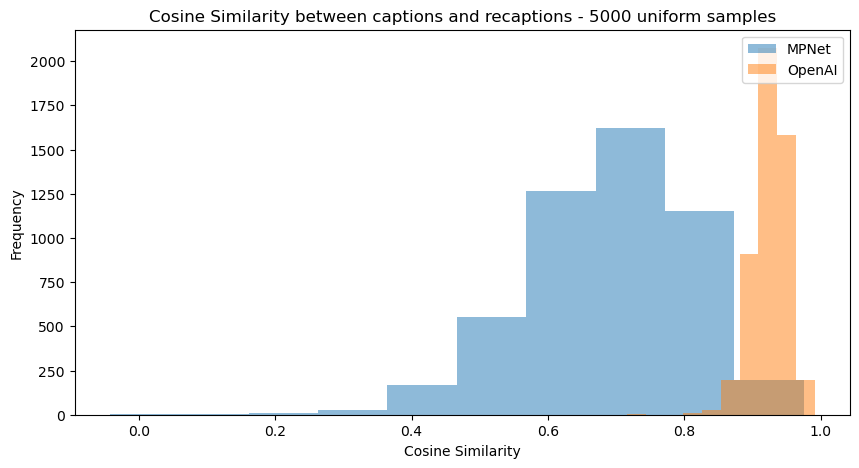

In [34]:
# Plot an overimposed histogram of the cosine similarities per MPNet and OpenAI
plt.figure(figsize=(10, 5))
plt.hist(df3['cosine_sim_mpnet'], bins=10, alpha=0.5, label='MPNet')
plt.hist(df3['cosine_sim_openai'], bins=10, alpha=0.5, label='OpenAI')
plt.legend(loc='upper right')
plt.title('Cosine Similarity between captions and recaptions - 5000 uniform samples')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [53]:
data_exp['cosine_sim_mpnet'] = data_exp.progress_apply(lambda row: cosine_sim_metric.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)

  0%|          | 0/42500 [00:00<?, ?it/s]

In [44]:
data_exp['cosine_sim_mpnet'].describe()

count    42500.000000
mean         0.692201
std          0.120035
min         -0.049704
25%          0.618009
50%          0.703642
75%          0.779243
max          0.975266
Name: cosine_sim_mpnet, dtype: float64

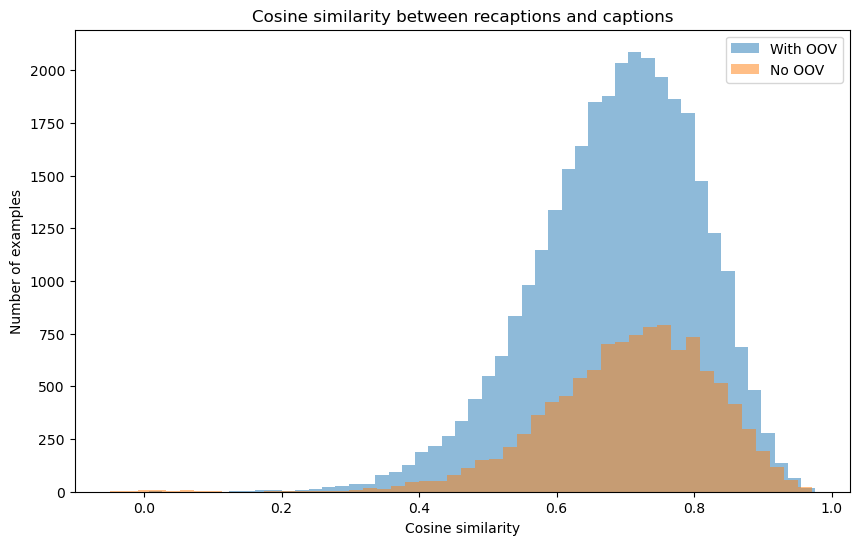

In [39]:
plt.figure(figsize=(10, 6))
# Histogram of cosine similarities for recaptions with no oov words
plt.hist(data_exp[data_exp['recaption_oov_words']>0]['cosine_sim_mpnet'], bins=50, alpha=0.5, label='With OOV')
plt.hist(data_exp[data_exp['recaption_oov_words']==0]['cosine_sim_mpnet'], bins=50, alpha=0.5, label='No OOV')
plt.legend(loc='upper right')
plt.title('Cosine similarity between recaptions and captions')
plt.xlabel('Cosine similarity')
plt.ylabel('Number of examples')
plt.show()

In [52]:
# Mean and std cosine similarity between caption and recaption with respect to number of OOV words

cosine_sim_vs_oov_df = pd.DataFrame(columns=['oov', 'mean', 'std'])
for oov in trange(0, max(data_exp['recaption_oov_words'].max(), data_exp_openai['recaption_oov_words'].max()) + 1):
    cosine_sim_vs_oov_df = pd.concat([cosine_sim_vs_oov_df, pd.DataFrame({
        'oov': oov,
        'mean': data_exp[data_exp['recaption_oov_words'] == oov]['cosine_sim_mpnet'].mean(),
        'std': data_exp[data_exp['recaption_oov_words'] == oov]['cosine_sim_mpnet'].std()
    }, index=[0])], ignore_index=True)

cosine_sim_vs_oov_df


  0%|          | 0/23 [00:00<?, ?it/s]

KeyError: 'cosine_sim_mpnet'

In [59]:
# Lineplot of the mean cosine similarity vs number of OOV words with std as error bars

fig = plt.subplots(figsize=(10, 6))
sns.lineplot(x="oov", y="cosine_similarity", data=df, ci="sd")



